# Elements of Data Science: A First Course 

# COMS W4995 008 2017 3


## Week 10: Statistical Modeling and Hypothesis Testing

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

%matplotlib inline

## Today:

- A/B Tests
- Hypothesis Testing
- Permutation Tests


## A/B Tests

Do one of two treatments produce superior results?

- testing two prices to determine which generates more profit

- testing two web headlines to determine which produces more clicks

- testing two advertisements to determine which produces more conversions

### Test Statistics / Metrics

- click vs no click
- buy vs no buy
- fraud vs no fraud
- differences in means
- differences in counts

## Hypothesis Testing

#### Null Hypothesis: $H_0$

#### Alternative Hypothesis: $H_1$


given data x: reject or accept the null hypothesis

<pre>
             H_0 true     | H_1 true
            ----------------------------
Accept H_0 | Correct        Type II error
Reject H_0 | Type I error   Correct
</pre>

- p(reject H_0 | H_0 true) = significance of test
- p(reject H_0 | H_1 true) = power of test

### Example: Which page leads to more sales?

**Proxy Variables**: a stand in for the true value of interest

Example: what if sales are large but infrequent

Proxy: Assume 'time on internal page' is correlated with sales

In [87]:
session_times = pd.read_csv('../data/web_page_data.csv')
session_times['Time'] = session_times['Time']*100
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


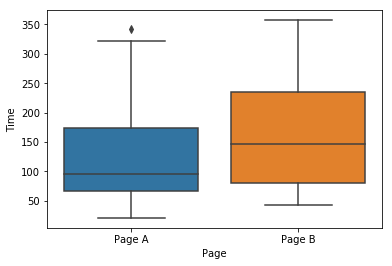

In [88]:
sns.boxplot(x='Page',y='Time',data=session_times)

In [89]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()

In [90]:
observed_metric = mean_b-mean_a
observed_metric

35.666666666666671

## Is this significant?

> Is this a surprising result given $H_0$?

## Permutation Tests

1. combine groups together
1. permute observations
1. generate new samples (same sizes as originals)
1. calculate metric
1. repeat many times
1. see where our original observation falls

In [91]:
# 0. get group sizes
n_a = sum(session_times.Page == 'Page A')
n_b = sum(session_times.Page == 'Page B')

In [92]:
# 1. combine groups together
samples = session_times.Time

In [93]:
# 2. permute observations
permuted = np.random.permutation(session_times.Time)

In [94]:
# 3. calculate metric
rand_mean_a = permuted[:n_a].mean()
rand_mean_b = permuted[n_a:].mean()
(rand_mean_b - rand_mean_a)

-54.390476190476193

In [95]:
# 4. repeat many times
mean_diffs = []
for i in range(10000):
    permuted = np.random.permutation(session_times.Time)
    rand_mean_a = permuted[:n_a].mean()
    rand_mean_b = permuted[n_a:].mean()
    mean_diffs.append(rand_mean_b - rand_mean_a)

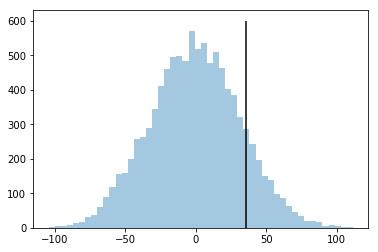

In [96]:
# 5. see where our original observation falls
ax = sns.distplot(mean_diffs, norm_hist=False, kde=False)
plt.vlines(mean_b-mean_a, *ax.get_ylim())

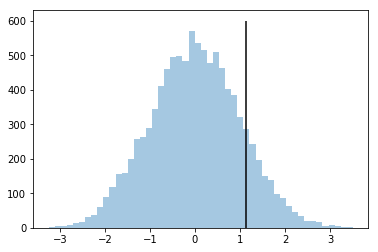

In [97]:
# 5. see where our original observation falls (normalized)
ax = sns.distplot((mean_diffs - np.mean(mean_diffs)) / np.std(mean_diffs), norm_hist=False, kde=False)
plt.vlines((observed_metric - np.mean(mean_diffs)) / np.std(mean_diffs), *ax.get_ylim())

## What's the probability? p-values

> The probability of finding the observed, or more extreme, results when the null hypothesis ($H_0$) is true.

- YES: $p\left(\text{data} \mid H_0 \text{ is true}\right)$

- NO!: $p(H_0 \text{ is not true} \mid \text{data})$

### Central Limit Theorem

For reasonably large samples (usually $n \ge 30$), the mean $\bar{x}$ has a gaussian distribution regardless of the distribution of $X$.

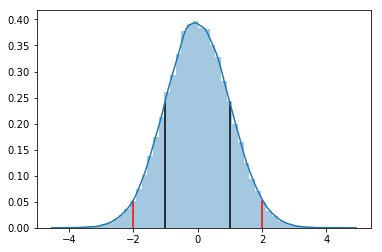

In [98]:
x = np.random.normal(0,1,size=100000)
_ = sns.distplot(x)
_ = plt.vlines([-1,1],0,sp.stats.norm.pdf(1), colors='k')
_ = plt.vlines([-2,2],0,sp.stats.norm.pdf(2), colors='r')

<img src="http://www.statisticshowto.com/wp-content/uploads/2013/09/standard-normal-distribution.jpg">

### Our question about signicance becomes:

> "How often did we see a value more extreme than our observed metric?"

In [99]:
# one-tailed
sum(np.array(mean_diffs) >= observed_metric)/ len(mean_diffs)

0.12939999999999999

### One-tailed vs Two-tailed

- Is there a default option (something we'll stick with)? One-tailed

- Do we have no initial preference for either? Two-tailed

In [100]:
# one-tailed
sum(np.array(mean_diffs) >= observed_metric)/ len(mean_diffs)

0.12939999999999999

In [101]:
# two-tailed
left_tail  = sum(np.array(mean_diffs) <= -observed_metric)
right_tail = sum(np.array(mean_diffs) >= observed_metric)
(left_tail + right_tail)/ len(mean_diffs)

0.26869999999999999

### Another Example: Which price leads to higher conversion?

In [102]:
df = pd.DataFrame({'Price A':[200,23539],'Price B':[182,22406]}, index=['Conversion','No Conversion'])
df

,Price A,Price B
Conversion,200,182
No Conversion,23539,22406


In [103]:
pct_conv = df.loc['Conversion'] / df.loc['No Conversion'] * 100
pct_conv

Price A    0.849654
Price B    0.812282
dtype: float64

### What's the metric of interest?

In [104]:
diff_pct_conv = pct_conv['Price A'] - pct_conv['Price B']
print('{:.4f}'.format(diff_pct_conv))

0.0374


Reminder:
1. combine groups together
1. permute observations
1. grab two new samples (same sizes as originals)
1. calculate metric
1. repeat many times
1. see where our original observation falls

### What are our samples?

- 1 = Conversion
- 0 = No conversion

### How many samples are there?

In [105]:
n = df.loc['No Conversion'].sum()
n

45945

### How do we generate our samples?

In [106]:
n_conversion = df.loc['Conversion'].sum()
n_conversion

382

In [107]:
samples = np.zeros(n)
samples[:n_conversion] = 1

In [108]:
sum(samples) == n_conversion

True

In [109]:
# 0. get group sizes
n_a, n_b = df.sum(axis=0)
n_a, n_b

(23739, 22588)

In [110]:
%%time
conv_diffs = []
for i in range(1000):
    permutation = np.random.permutation(samples)
    rand_conv_a = sum(permutation[:n_a]) / n_a
    rand_conv_b = sum(permutation[n_a:]) / n_b
    conv_diffs.append(100 * (rand_conv_a - rand_conv_b))

CPU times: user 6.18 s, sys: 0 ns, total: 6.18 s
Wall time: 6.17 s


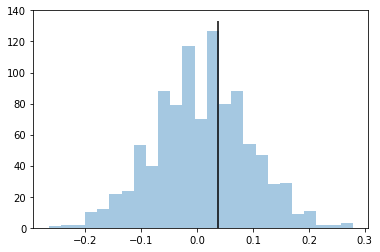

In [111]:
ax = sns.distplot(conv_diffs, norm_hist=False, kde=False)
plt.vlines(diff_pct_conv, *ax.get_ylim())

In [112]:
sum(np.array(conv_diffs) >= diff_pct_conv) / len(conv_diffs)

0.35299999999999998

### Another method: t-test

In [113]:
# using our session_times example
t = sp.stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time.values,
                       session_times[session_times.Page == 'Page B'].Time.values,
                       equal_var=False)
t.pvalue

0.28152437245700612

In [114]:
t.pvalue/2

0.14076218622850306

In [115]:
from statsmodels.stats.weightstats import ttest_ind

In [116]:
ttest_ind(session_times[session_times.Page == 'Page A'].Time.values,
                       session_times[session_times.Page == 'Page B'].Time.values,
                       usevar='unequal',
                       alternative='smaller')
# t stat, p value, df

(-1.098315562363811, 0.1407621862285032, 27.693370059531322)

In [117]:
# using our conversion rate example?
group_A = np.zeros(n_a)
group_A[:df.loc['Conversion','Price A']] = 1

group_B = np.zeros(n_b)
group_B[:df.loc['Conversion','Price B']] = 1

In [118]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(df.loc['Conversion'],[n_a,n_b],
                  value=0, # value of H_0
                  alternative='larger'
                 )
# z stat, p value

(0.43730778694245098, 0.33094407441560325)

## Confidence Intervals

> "A 90% confidence interval is the interval that encloses the central 90% of the bootstrap sampling distribution"

**bootstrapping**: sampling with replacement 

**Bootstrap Confidence Interval**:

1. draw a random sample with replacement
1. record statistic of interest
1. repeat many times
1. x% confidence interval, trim [(1-x/100) / 2]% resample results from either end

In [119]:
sample_means = []
for i in range(100):
    bootstrap = []
    for j in range(100):
        idx_r = np.random.randint(0, len(mean_diffs))
        bootstrap.append(mean_diffs[idx_r])
    sample_means.append(np.mean(bootstrap))

(array([  2.,   3.,   4.,  13.,  18.,  22.,  16.,  11.,   9.,   2.]),
 array([-9.17904762, -7.5207619 , -5.86247619, -4.20419048, -2.54590476,
        -0.88761905,  0.77066667,  2.42895238,  4.0872381 ,  5.74552381,
         7.40380952]),
 <a list of 10 Patch objects>)

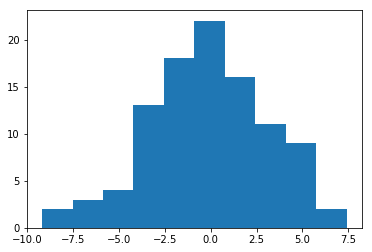

In [120]:
plt.hist(sample_means)

In [121]:
trim = ((1-(90/100)) / 2) * len(mean_diffs)
trim

499.9999999999999

In [122]:
s = np.sort(mean_diffs)

In [123]:
s[int(trim)-1]

-53.933333333333323

In [124]:
np.sort(mean_diffs)[-int(trim)]

52.35238095238094

In [125]:
import scipy.stats as st

st.t.interval(0.90,              # alpha
              len(mean_diffs)-1, # shape parameter
              loc=np.mean(mean_diffs),
              scale = st.sem(mean_diffs))

(-0.98494942602837121, 0.063037045075989506)

## How many observations do we need?

**effect size**: Min size of effect you want to detect (think "%10 increase in clicks")

**power**: Probability of detecting given effect size with given sample size, $p(\text{reject } H_0 \mid H_1 \text{ true})$

**alpha**: significance level at which to reject the null, $p(\text{reject }H_0 \mid H_0 \text{ true})$

**number of observations**: usually what we're insterested in finding

In [126]:
from statsmodels.stats.power import tt_ind_solve_power

In [127]:
# choose one to set as None
tt_ind_solve_power(effect_size=.05, # difference between means divided by std deviation
                   nobs1=None, 
                   alpha=.05,       # incorrect rejection of a true alternative
                   power=.95,        # 1 - incorrect acceptance of a false null
                   ratio=1          # n_a : n_b
                  )

10396.728892909725

In [128]:
# choose one to set as None
tt_ind_solve_power(effect_size=.5, # difference between means divided by std deviation
                   nobs1=None, 
                   alpha=.05,       # incorrect rejection of a true alternative
                   power=.9,        # 1 - incorrect acceptance of a false null
                   ratio=1          # n_a : n_b
                  )

85.03128688801092

## Issues with multiple testing

- for instance, what if there are more than 2 groups?

- ANOVA

- Multi-Armed Bandit

### $\epsilon$-Greedy MAB

- choose a small $\epsilon$

1. generate random number between 0 and 1
1. if $\lt \epsilon$, roll a die to choose arm
1. if $\ge \epsilon$, choose best arm

### Variations

- "Thompson's sampling": uses Baysian approach

- UCB1: maximize expected reward (for arm $j$: $\bar{x}_j + \sqrt{2\log t / n_j}$)

## Imbalanced Classes

- Stratified sampling

In [129]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(10)
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
     print("%s %s" % (train, test))


[2 3 6 7 8 9] [0 1 4 5]
[0 1 3 4 5 8 9] [2 6 7]
[0 1 2 4 5 6 7] [3 8 9]


- Oversample minority class 

- Undersample majority class 

In [130]:
# conda install -c glemaitre imbalanced-learn -n coms_4995

In [134]:
from sklearn.datasets import make_classification
from collections import Counter
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

In [139]:
Counter(y).items()

dict_items([(2, 4674), (1, 262), (0, 64)])

In [133]:
print(sorted(Counter(y).items()))

TypeError: 'numpy.ndarray' object is not callable

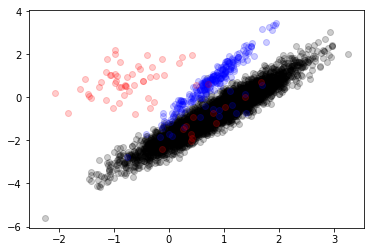

In [140]:
plt.scatter(X[y==2,0],X[y==2,1],c='k', alpha=.2)
plt.scatter(X[y==1,0],X[y==1,1],c='b', alpha=.2)
plt.scatter(X[y==0,0],X[y==0,1],c='r', alpha=.2)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_r, y_r = ros.fit_sample(X, y)
from collections import Counter
print(sorted(Counter(y_r).items()))

In [ ]:
plt.scatter(X_r[y_r==2,0],X_r[y_r==2,1],c='k', alpha=.2)
plt.scatter(X_r[y_r==1,0],X_r[y_r==1,1],c='b', alpha=.2)
plt.scatter(X_r[y_r==0,0],X_r[y_r==0,1],c='r', alpha=.2)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_r, y_r, = rus.fit_sample(X, y)
from collections import Counter
print(sorted(Counter(y_r).items()))

In [ ]:
plt.scatter(X_r[y_r==0,0],X_r[y_r==0,1],c='r', alpha=.2)
plt.scatter(X_r[y_r==1,0],X_r[y_r==1,1],c='b', alpha=.2)
plt.scatter(X_r[y_r==2,0],X_r[y_r==2,1],c='k', alpha=.2)

Create new minority class items

In [ ]:
# Synthetic Minority Oversampling
from imblearn.over_sampling import SMOTE

X_r, y_r = SMOTE().fit_sample(X, y)
print(sorted(Counter(y_r).items()))

In [ ]:
plt.scatter(X_r[y_r==2,0],X_r[y_r==2,1],c='k', alpha=.2)
plt.scatter(X_r[y_r==1,0],X_r[y_r==1,1],c='b', alpha=.2)
plt.scatter(X_r[y_r==0,0],X_r[y_r==0,1],c='r', alpha=.2)

In [ ]:
# Adaptive Synthetic Minority Oversampling
from imblearn.over_sampling import ADASYN

X_r, y_r = ADASYN().fit_sample(X, y)
print(sorted(Counter(y_r).items()))

In [ ]:
plt.scatter(X_r[y_r==2,0],X_r[y_r==2,1],c='k', alpha=.2)
plt.scatter(X_r[y_r==1,0],X_r[y_r==1,1],c='b', alpha=.2)
plt.scatter(X_r[y_r==0,0],X_r[y_r==0,1],c='r', alpha=.2)

- Adjust class weight (sklearn)

- Adjust decision threshold (sklearn)

- Treat as anomaly detection

- Buy more data